This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import gc
import re
import math
import random
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
from tqdm.auto import tqdm
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib

class CFG:
    seed = 46
    train = True
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

sns.set_style("darkgrid")

# %cd /content/drive/MyDrive/kaggle/foursquare-location-matching/{CFG.expID}

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 600)

# Get the dataset

In [3]:
train = pd.read_parquet("foursquare-location-matching-parquet/train.parquet")
test = pd.read_parquet("foursquare-location-matching-parquet/test.parquet")
test[CFG.target] = "TEST"

train.head(5)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,None,None,Bars,P_677e840bb6fc7e
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,None,None,None,None,BR,None,None,Brazilian Restaurants,P_d82910d8382a83
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,None,None,None,None,TH,None,None,Salons / Barbershops,P_b1066599e78477
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,None,None,None,TR,None,None,Mobile Phone Shops,P_b2ed86905a4cd3
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,None,Caviedes,Cantabria,None,ES,None,None,Spanish Restaurants,P_809a884d4407fb


# 1. EDA

## Train shape and dtypes

In [4]:
print(f"Train shape is {train.shape}\n")

train.dtypes

Train shape is (1138812, 13)



id                    object
name                  object
latitude             float64
longitude            float64
address               object
city                  object
state                 object
zip                   object
country               object
url                   object
phone                 object
categories            object
point_of_interest     object
dtype: object

### Train nulls

In [5]:
train.isnull().sum()

id                        0
name                      1
latitude                  0
longitude                 0
address              396621
city                 299189
state                420586
zip                  595426
country                  11
url                  871088
phone                795957
categories            98307
point_of_interest         0
dtype: int64

## ID

In [6]:
assert len(train) == len(train['id'].unique())

## Name

### Unique values

In [7]:
print(f"Number of unique names is {len(train['name'].unique())}")

Number of unique names is 842087


### Plot most popular names

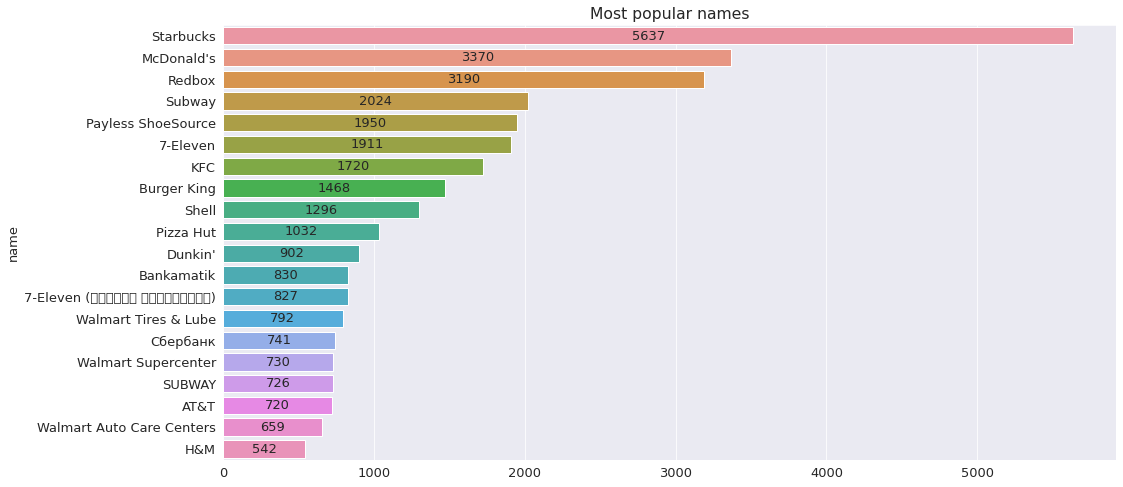

In [8]:
plt.figure(figsize=(16, 8))
plt.title('Most popular names')

d = train['name'].value_counts().head(20).sort_values(ascending=False)
ax = sns.barplot(x=d.values, y=d.index, data=d, orient='h', order=d.values)
ax.set_yticklabels(d.index)
br = ax.bar_label(ax.containers[0], label_type='center')

## Get main categories

In [9]:
cat_freq = dict()
stop_words = ['/', '&', 'or', 'High', 'Miscellaneous', 'Fast', 'Other', 'Asian', 'Chinese', 'Event', 
              'Great', 'Noodle', 'Burger', 'Seafood', 'Breakfast', 'Ice', 'Diners', 'Cream', 'Indonesian', 
              'Thai', "Women's", 'Fried', 'Snack', 'Tea', 'Mexican', 'Nail', 'Sushi', 'Middle', 'Korean', 
              'Gift', 'Drink', 'Pet', 'Turkish', "Men's", 'Indian', 'Malay', 'Cocktail', 'Donut', 'Box', 
              'Condos)', 'Residential', 'Convenience', 'Gas', 'General', 'Bus', 'Pizza', 'Spaces', 'Mobile',
              'Phone', 'Academic', 'Japanese', 'Business', 'Shoe', 'Italian', 'American', 'Home', 'Auto', 
              'Furniture', 'Cosmetics', 'Sandwich', 'Dessert', 'Car', 'Arts', 'Financial', 'Legal', 'BBQ',
              'Hardware', 'Video', 'Music', 'Art', 'Student', 'Jewelry', 'Historic', 'Travel', 'Washes',
              'Beer', 'Arcades', 'Bike', 'Lookouts', 'Scenic', 'Rental', 'Accessories', 'Repairs', 'Discount', 
              'Optical', 'Bodegas', 'Big', 'Assisted', 'Living', 'Athletics', 'Agencies', 'Locations', 'Trails', 
              'Bed', 'Breakfasts', 'Wine', 'Real', 'Elementary', 'Theme', 'Golf', 'Rest',  'Photography', 
              'Nightlife', 'Courses', 'Convention', 'Eastern', 'Concert', 'Conference', 'Startups', 'Tech', 
              'Meeting', 'French', 'Supplies', 'Events', 'Sake', 'Dog', 'Ramen', 'City', 'Juice', 'Science',
              'Liquor', 'Lawyers', 'Insurance', 'Flower', 'Toy', 'Rentals', 'Paper', 'Flea', 'Bases', 'Baseball', 
              'Karaoke', 'Kids', 'Design', 'Farmers', 'Repair', 'Technology', 'Wards', 'Water', 'Supply', 
              'Filipino', 'Piers', 'Salad', 'Mattress', 'Print', 'Wings', 'Engineering', 'Non-Profits', 
              'Gastropubs', 'Bistros', 'Hot', 'Vietnamese', 'Hookah', 'Candy', 'Coffee', 'Electronics',
              'Department', 'Clothing', 'Trucks', 'Chicken', 'Movie', 'Health', 'Soccer', 'Crafts', 
              'Game', 'Community', 'Food', 'College', 'Sporting', 'Beauty', 'Ferries', 'Soup', 'Veterinarians', 
              'Basketball', 'Light', 'Rail', 'Taco', 'Classrooms', 'Shopping', 'Developments', 'Train', 'Performing',
              'Administrative', 'Lingerie', 'Dive', 'Storage', 'Office', 'Landscaping', 'Residence', 'Sports',
              'Goods', 'Dealerships', 'Grocery', 'Workshops', 'History'
             ]


def get_categories(category):
    if category == 'Auto':
        return 'Automotive'
    if category == 'Hotel' or c == 'Motels' or c == 'Hostels':
        return 'Hotels'
    if category == 'Courthouses':
        return 'Court'
    if category == 'College':
        return 'Colleges'
    if category == 'Cafés':
        return 'Cafes'
    if category == "Doctor's" or c == "Dentist's" or c == "Doctors":
        return 'Medical'
    if category == '(Apartments':
        return 'Apartments'
    return category
    

for category in tqdm(train['categories']):
    if category is not None:
        category_list = re.split(', | ', category)
        for c in category_list:
            if c in stop_words or c[-2:] == 'an':
                continue
            c = get_categories(c)
            x = cat_freq.get(c, 0) + 1
            cat_freq[c] = x

            
cat_freq = pd.DataFrame(cat_freq.items(), 
                        columns=['category', 'frequence']).sort_values('frequence', 
                                                                        ascending=False).reset_index(drop=True)
cat_freq = cat_freq.iloc[:108]
cat_freq.head()

  0%|          | 0/1138812 [00:00<?, ?it/s]

,category,frequence
0,Restaurants,146728
1,Stores,129584
2,Shops,109316
3,Buildings,73062
4,Offices,50046


### Plot most popular main categories

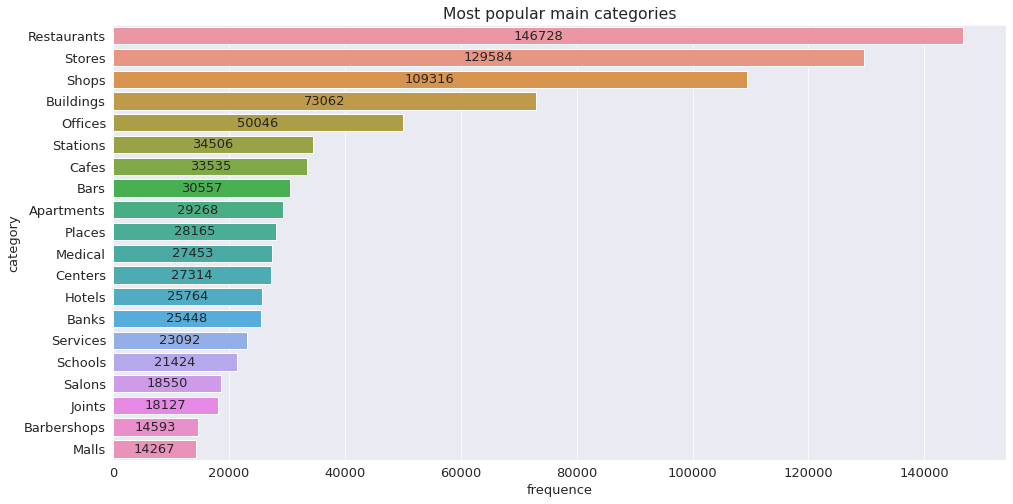

In [10]:
plt.figure(figsize=(16, 8))
plt.title('Most popular main categories')

d = cat_freq.head(20)
ax = sns.barplot(x='frequence', y='category', data=d, orient='h')
br = ax.bar_label(ax.containers[0], label_type='center')

## Lattitude and longitude



### 10 most popular lat and lon values

In [11]:
lat_lon_group = train.groupby(['latitude', 'longitude'], as_index=False).agg({'id': 'count', 
                                                                              'name': 'first'}).rename({'id': 'count'}, axis=1).sort_values('count', 
                                                                                                                                            ascending=False)
lat_lon_group.head(10)

,latitude,longitude,count,name
678212,38.415602,-95.925751,1437,gucci男士内裤-一比一原单A货奢侈品他
694126,38.748285,30.548825,48,Emniyet Parkı
725211,39.779379,-75.555298,45,"Cara J. Lasley, MD"
114208,-6.914744,107.609811,38,XI IPA 4 SMAN 25 Bandung
905361,44.480641,-73.196685,36,"Adam Preston Buckley, MD"
192734,1.311910,124.837240,22,El Pollo Gordo Restaurant
193370,1.317170,124.838060,20,Southern Fried Chicken Restaurants
678151,38.413248,-95.925751,20,"Collection - 哪里买一比一lv迷你双肩包货源,哪里有卖瓜"
969105,50.000000,5.000000,19,Champia - Arrêt de bus TEC
145913,-6.211544,106.845172,18,"""Waroeng Spesial Sambal \""SS\"""""


### Unique lat and lon pairs

In [12]:
len(lat_lon_group)

1128847

## City

### Unique values

In [13]:
print(f"Number of unique cities is {len(train['city'].unique())}")

Number of unique cities is 68106


### Most popular cities

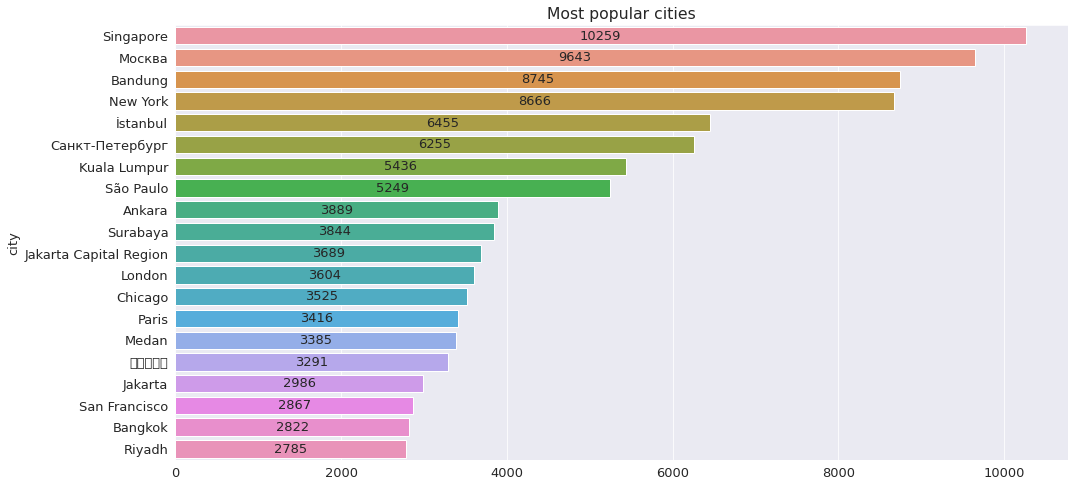

In [14]:
plt.figure(figsize=(16, 8))
plt.title('Most popular cities')

d = train['city'].value_counts().head(20).sort_values(ascending=False)
ax = sns.barplot(x=d.values, y=d.index, data=d, orient='h', order=d.values)
ax.set_yticklabels(d.index)
br = ax.bar_label(ax.containers[0], label_type='center')

## State

### Unique values

In [15]:
print(f"Number of unique states is {len(train['state'].unique())}")

Number of unique states is 17597


### Most popular states

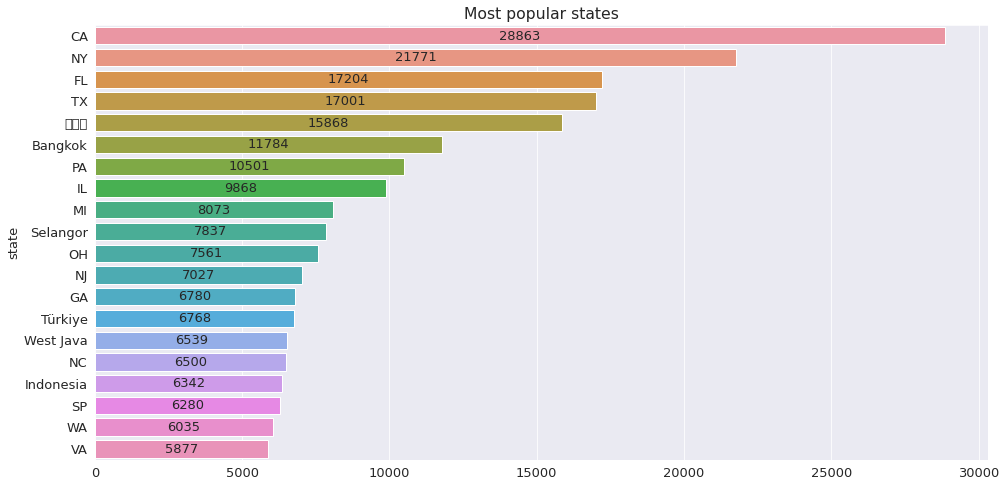

In [16]:
plt.figure(figsize=(16, 8))
plt.title('Most popular states')

d = train['state'].value_counts().head(20).sort_values(ascending=False)
ax = sns.barplot(x=d.values, y=d.index, data=d, orient='h', order=d.values)
ax.set_yticklabels(d.index)
br = ax.bar_label(ax.containers[0], label_type='center')

## Country

### Unique values

In [17]:
print(f"Number of unique countries is {len(train['country'].unique())}")

Number of unique countries is 222


### Most popular countries

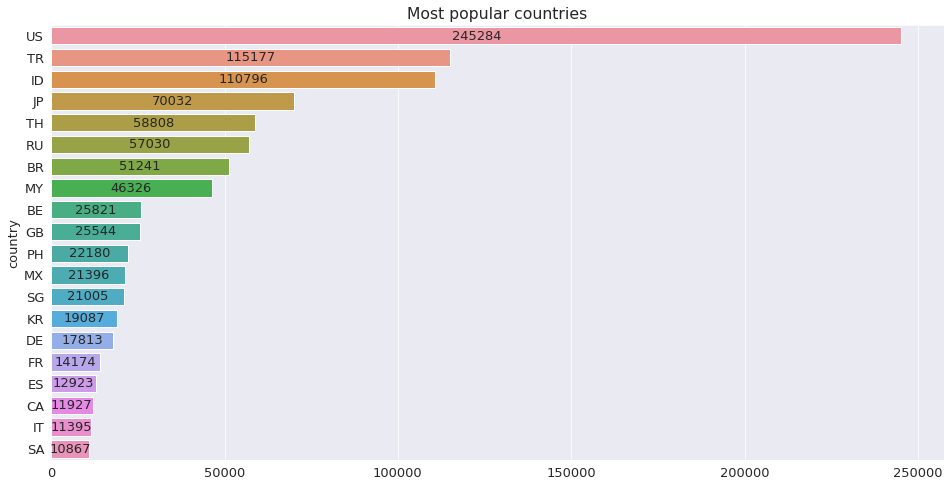

In [18]:
plt.figure(figsize=(16, 8))
plt.title('Most popular countries')

d = train['country'].value_counts().head(20).sort_values(ascending=False)
ax = sns.barplot(x=d.values, y=d.index, data=d, orient='h', order=d.values)
ax.set_yticklabels(d.index)
br = ax.bar_label(ax.containers[0], label_type='center')

## Points of interest

### Unique values

In [19]:
print(f"Number of unique categories is {len(train['point_of_interest'].unique())}")

Number of unique categories is 739972


### Most popular POIs

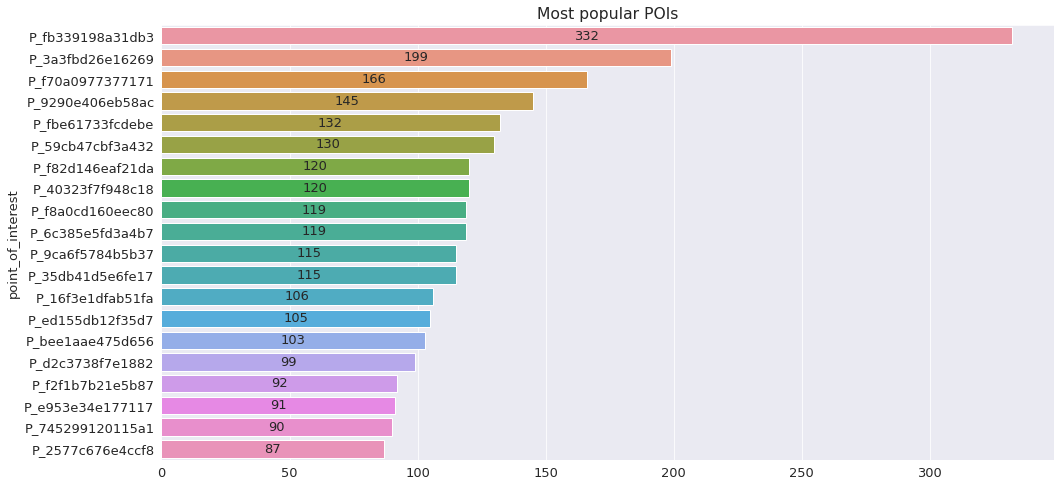

In [20]:
plt.figure(figsize=(16, 8))
plt.title('Most popular POIs')

d = train['point_of_interest'].value_counts().head(20).sort_values(ascending=False)
ax = sns.barplot(x=d.values, y=d.index, data=d, orient='h', order=d.values)
ax.set_yticklabels(d.index)
br = ax.bar_label(ax.containers[0], label_type='center')

### Count number of POI without match

In [21]:
group_poi = train.groupby('point_of_interest', as_index=False).agg({'id': 'count'})
group_poi[group_poi['id'] == 1].shape[0]

425024